In [1]:
%%capture
!pip install pydicom
!pip install sklearn
from apex import amp
import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from torch.utils.data import DataLoader
import sklearn

In [2]:
os.listdir('../data')

['test.csv',
 'stage_1_sample_submission.csv.zip',
 'stage_1_sample_submission.csv',
 'stage_1_test_images_jpg',
 'stage_1_train.csv.zip',
 'rsna_512.zip',
 'test.csv.gz',
 'nohup1.out',
 'stage_1_train.csv',
 'nohup.out',
 'stage_1_train_images_jpg',
 'train.csv.gz']

In [3]:
# Input
dir_csv = '../data'
dir_train_img = os.path.join(dir_csv, 'stage_1_train_images_jpg')
dir_test_img = os.path.join(dir_csv, 'stage_1_test_images_jpg')

# Parameters
n_classes = 6
n_epochs = 1
batch_size = 16
label_cols = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']

In [4]:
class IntracranialDataset(Dataset):

    def __init__(self, df, path, labels, transform=None):
        self.path = path
        self.data = df
        self.transform = transform
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.path, self.data.loc[idx, 'Image'] + '.jpg')
        img = cv2.imread(img_name)         
        if self.transform:       
            augmented = self.transform(image=img)
            img = augmented['image']   
        if self.labels:
            labels = torch.tensor(
                self.data.loc[idx, label_cols])
            return {'image': img, 'labels': labels}    
        else:      
            return {'image': img}

In [5]:
# CSVs
train = pd.read_csv(os.path.join(dir_csv, 'train.csv.gz'))
test = pd.read_csv(os.path.join(dir_csv, 'test.csv.gz'))
png = glob.glob(os.path.join(dir_train_img, '*.jpg'))
png = [os.path.basename(png)[:-4] for png in png]
png = np.array(png)
train = train.set_index('Image').loc[png].reset_index()

In [6]:
# get fold
valdf = train[train['fold']==0].reset_index(drop=True)[:1000]
trndf = train[train['fold']!=0].reset_index(drop=True)

In [7]:
# Data loaders
transform_train = Compose([
    ShiftScaleRotate(),
    ToTensor()
])

transform_test= Compose([
    ToTensor()
])

trndataset = IntracranialDataset(trndf, path=dir_train_img, transform=transform_train, labels=True)
valdataset = IntracranialDataset(valdf, path=dir_train_img, transform=transform_train, labels=False)
tstdataset = IntracranialDataset(test, path=dir_test_img, transform=transform_test, labels=False)

In [8]:
batch_size = 16
num_workers = 0
trnloader = DataLoader(trndataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = DataLoader(valdataset, batch_size=batch_size*4, shuffle=False, num_workers=num_workers)
tstloader = DataLoader(tstdataset, batch_size=batch_size*4, shuffle=False, num_workers=num_workers)

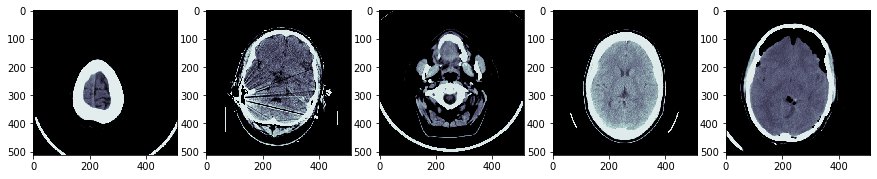

In [9]:
batch = next(iter(valloader))
fig, axs = plt.subplots(1, 5, figsize=(15,5))
for i in np.arange(5):
    axs[i].imshow(np.transpose(batch['image'][i].numpy(), (1,2,0))[:,:,0], cmap=plt.cm.bone)

In [10]:
# Model
device = torch.device("cuda:0")
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
model.fc = torch.nn.Linear(2048, n_classes)

model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
plist = [{'params': model.parameters(), 'lr': 2e-5}]
optimizer = optim.Adam(plist, lr=2e-5)

model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [11]:
%%capture
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# Train
del tqdm
from tqdm import tqdm

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)
    model.train()    
    tr_loss = 0
    tk0 = tqdm(trnloader, desc="Iteration")
    for step, batch in enumerate(tk0):
        inputs = batch["image"]
        labels = batch["labels"]
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        tr_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        del inputs, labels, outputs
    epoch_loss = tr_loss / len(trnloader)
    print('Training Loss: {:.4f}'.format(epoch_loss))
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    valls = []
    tk1 = tqdm(valloader, desc="Iteration")
    for step, batch in enumerate(tk1):
        inputs = batch["image"]
        inputs = inputs.to(device, dtype=torch.float)
        out = model(inputs)
        valls.append(torch.sigmoid(out).detach().cpu().numpy())
    weights = ([1, 1, 1, 1, 1, 2] * valdf.shape[0])
    valloss = log_loss(valdf[label_cols].values.flatten(), \
                    np.concatenate(valls, 0).flatten(), \
                    sample_weight = weights)
    print('Epoch {} logloss {}'.format(epoch, valloss))
    output_model_file = 'model_v1_epoch{}.bin'.format(epoch)
    torch.save(model.state_dict(), output_model_file)

Iteration:   0%|          | 0/31606 [00:00<?, ?it/s]

Epoch 0/0
----------


Iteration:   0%|          | 1/31606 [00:03<32:05:33,  3.66s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


Iteration:   0%|          | 32/31606 [01:08<18:40:07,  2.13s/it]

In [ ]:
inputs.shape